In [18]:
# from modeldef import *

# class Place(FxnBlock):
#     def __init__(self,flows):
#         super().__init__(['People_Out'],flows, {'Infected':100.0,'Susceptible':500.0,'Recovered':0.0})
#         self.failrate=1e-5
#         self.assoc_modes({'na':[1.0, [1,1,1], 1]})
#     def behavior(self,time):
#         Infect_rate = 10.0 * self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered)
#         Recover_Rate =  self.Infected / 1.25
#         if time>self.time:
#             self.Infected = self.Infected + 0.05 * (Infect_rate - Recover_Rate)
#             self.Susceptible = self.Susceptible - 0.05 * Infect_rate
#             self.Recovered = self.Recovered + 0.05 * Recover_Rate 
       
# class DiseaseModel(Model):
#     def __init__(self, params={}):
        
               
#         self.times = [1,140]
#         self.tstep = 1
        
#         self.add_flow('People_campus_living', 'People', {'Infected':100,'Susceptible':100,'Recovered':100})
#         self.add_flow('People_campus_downtown', 'People', {'Infected':100,'Susceptible':100,'Recovered':100})
#         self.add_flow('People_downtown_living', 'People', {'Infected':100,'Susceptible':100,'Recovered':100})
        
#         self.add_fxn('Campus',Place,['People_campus_living', 'People_campus_downtown'])
#         self.add_fxn('Downtown',Place,['People_campus_downtown','People_downtown_living'])
#         self.add_fxn('Living',Place,['People_campus_living', 'People_downtown_living'])
        
        
#         self.construct_graph()
    
#     def find_classification(self,resgraph, endfaults, endflows, scen, mdlhists):
#         rate=1
#         totcost=1
#         expcost=1
        
#         return {'rate':rate, 'cost': totcost, 'expected cost': expcost}

In [70]:
from modeldef import *


class Place(FxnBlock):
    def __init__(self,flows, params):
        population = params[0]['pop']
        self.extra = params[0]['extra']
        super().__init__(['Transport'],flows, {'Infected':population/10,'Susceptible':population*9/10,'Recovered':0.0})
        self.failrate=1e-5
        self.assoc_modes({'PL1':[1.0, [1,1,1], 1],'PL2':[1.0, [1,1,1], 1]})
        self.m = 2
        self.n = 0
        self.c = (self.n+self.m)/(self.m)
    def confaults(self,time):
        # policy 1: if infect rate bigger than 1, add 2 medical staff per day,  infectious time will drop from 1.25 to 1.25/2
        # policy 2: if infected people bigger than 15%, contact rate will drop from 10 to 2 , susceptible people will get vaccine,5 people/day
        if self.Infected/(self.Susceptible + self.Infected + self.Recovered)> 0.15: 
            self.add_fault('PL2')
        if (10.0 * self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)) > 1:
            self.add_fault('PL1')            
        
            
    def behavior(self,time):
        if self.has_fault('PL2'):
            # m is default medical staff number ? how
            # n is increased medical staff number , 2 per step
            # c=(n+m)/m
            self.n+=2 
            self.c=(self.n+self.m)/(self.m)
            Infect_rate = 10.0 * self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)
            Recover_Rate = self.c * self.Infected / (1.25/2)
            
            if time>self.time:
                self.Infected += 0.05* (Infect_rate - Recover_Rate)
                self.Susceptible -= 0.05* Infect_rate
                self.Recovered += 0.05* Recover_Rate
            
            
        if self.has_fault('PL1'):
            # v is the number of people who get vaccine per step, in this case v=5
            # contact rate a will decrease, from 10 to 2 in this case
            v=5
            Infect_rate= 2 * self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)
            Recover_Rate = self.c * self.Infected / (1.25/2)
            
            if time>self.time:
                self.Infected += 0.05* (Infect_rate - Recover_Rate)
                self.Susceptible -= (0.05* Infect_rate-v)
                self.Recovered += (0.05* Recover_Rate+v)           
            
        # nominal state    
        Infect_rate = 10.0 * self.Susceptible * self.Infected / (self.Susceptible + self.Infected + self.Recovered + 0.001)
        Recover_Rate =  self.Infected / 1.25
        Leave_Rate = 0.5
       
        if time>self.time:
            self.Infected += 0.05* (Infect_rate - Recover_Rate)
            self.Susceptible -= 0.05* Infect_rate
            self.Recovered += 0.05* Recover_Rate
#             if self.extra:
#                 self.Infected += 2
#                 self.Recovered -= 2
            # Arriving/Leaving
            self.Infected += self.Transport.In_I  - self.Transport.Out_I 
            self.Susceptible += self.Transport.In_S  - self.Transport.Out_S 
            self.Recovered += self.Transport.In_R - self.Transport.Out_R
            self.Transport.Stay_I  = self.Infected
            self.Transport.Stay_S  = self.Susceptible
            self.Transport.Stay_R  = self.Recovered
            

class Transit(FxnBlock):
    def __init__(self,flows):
        super().__init__(['T_Campus', 'T_Downtown', 'T_Living'],flows)
        self.failrate=1e-5
        self.assoc_modes({'na':[1.0, [1,1,1], 1]})
    def behavior(self,time):
        C_to_L = 0.1
        D_to_C = 0.1
        L_to_D = 0.1
        
        if time > self.time:
            self.T_Campus.Out_I = C_to_L * self.T_Campus.Stay_I
            self.T_Campus.Out_S = C_to_L * self.T_Campus.Stay_S
            self.T_Campus.Out_R = C_to_L * self.T_Campus.Stay_R 
            
            self.T_Downtown.Out_I = D_to_C * self.T_Downtown.Stay_I
            self.T_Downtown.Out_S = D_to_C * self.T_Downtown.Stay_S
            self.T_Downtown.Out_R  = D_to_C * self.T_Downtown.Stay_R 
            
            self.T_Living.Out_I = L_to_D * self.T_Living.Stay_I
            self.T_Living.Out_S = L_to_D * self.T_Living.Stay_S
            self.T_Living.Out_R  = L_to_D * self.T_Living.Stay_R          
            
            
            self.T_Downtown.In_I = self.T_Campus.Out_I
            self.T_Downtown.In_S = self.T_Campus.Out_S
            self.T_Downtown.In_R  = self.T_Campus.Out_R 
            
            self.T_Campus.In_I = self.T_Living.Out_I
            self.T_Campus.In_S = self.T_Living.Out_S
            self.T_Campus.In_R  = self.T_Living.Out_R  
            
            self.T_Living.In_I = self.T_Downtown.Out_I
            self.T_Living.In_S = self.T_Downtown.Out_S
            self.T_Living.In_R  =  self.T_Downtown.Out_R 
            
            
        
class DiseaseModel(Model):
    def __init__(self, params={}):
        super().__init__()
        
        self.times = [1,50]
        self.tstep = 1
        
        travel = {'In_I':0,'In_S':0,'In_R':0,'Out_I':0,'Out_S':0,'Out_R':0,'Stay_I':0,'Stay_S':0,'Stay_R':0}
        self.add_flow('Travel_Campus', 'People', travel)
        self.add_flow('Travel_Downtown', 'People', travel)
        self.add_flow('Travel_Living', 'People', travel)
        
        self.add_fxn('Campus',Place,['Travel_Campus'],{'pop':100.0,'extra':False})
        self.add_fxn('Downtown',Place,['Travel_Downtown'], {'pop':1000.0,'extra':True})
        self.add_fxn('Living',Place,['Travel_Living'], {'pop':100.0,'extra':False})
        self.add_fxn('Movement', Transit, ['Travel_Campus','Travel_Downtown','Travel_Living'])
        
        
        self.construct_graph()
    def find_classification(self,resgraph, endfaults, endflows, scen, mdlhists):
        rate=1
        totcost=1
        expcost=1
        
        return {'rate':rate, 'cost': totcost, 'expected cost': expcost}

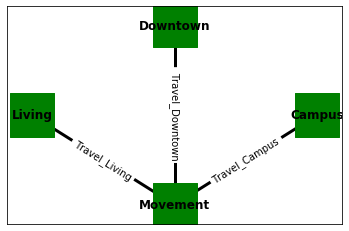

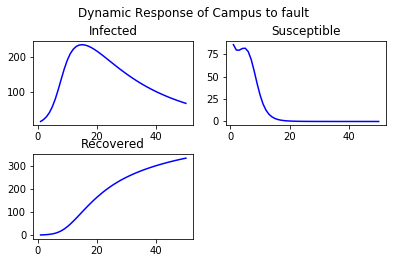

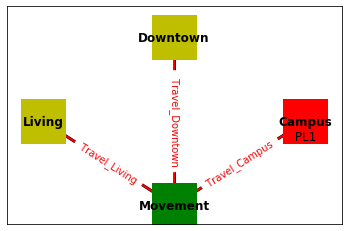

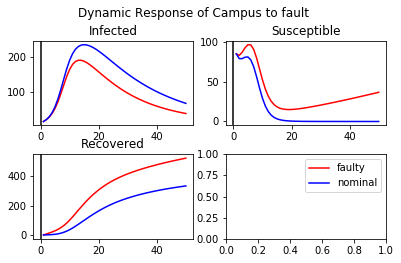

In [77]:
import sys
sys.path.append('../')
import pandas as pd
import faultprop as fp
import resultproc as rp
import csv
#from disease_model import *

dm1 = DiseaseModel()

rp.show_graph(dm1.graph)

endresults, resgraph, mdlhist_nom = fp.run_nominal(dm1)

rp.plot_mdlhist(mdlhist_nom, fxnflows=['Campus'])

normal_state_table = rp.make_histtable(mdlhist_nom)
# print(normal_state_table)

# rp.plot_mdlhist(mdlhist)

endresults, resgraph, mdlhist_pl1 = fp.run_one_fault(dm1,'Campus','PL1', time=1)
PL1_state_table = rp.make_histtable(mdlhist_pl1)
# print(PL1_state_table)
rp.show_graph(resgraph)
rp.plot_mdlhist(mdlhist_pl1, fxnflows=['Campus'])

In [72]:
type(PL1_state_table)
PL1_state_table.to_csv('PL1_state_table.csv')
normal_state_table.to_csv('normal_state_table.csv')

In [51]:
# class house(Place):
    
    
    
# class campus(Place):
    
# class downtown(Place):


# class people(flow):

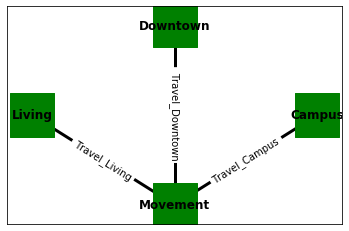